## Chapter 6 : Using a Neural Network to Fit the data

In this chapter we will use a more complex model to solve the same conversion of the fahremheit to celsius model. We could use a quadratic model of type `ax^2 + bx + c` to make our model better or other funciton as long as the function is differentiable, pytoch will be able to backpropagate the gradients and fit our data and the training loop will work as usual. But that would not be too interesting because we would just be fixin the shape of the function.

So in this chapter rather than explicitly defining the function to fit our data and then fitting it, we would just define a neural network and make it learn the underlying function of our data by adjusting the parameters.

#### Understanding the error function
1. So far the model that we have been using is a simple linear model and now we will be using a Neural Network. One major difference between the linear model and the NN is the shape of the error function/loss function. The error function of the linear model is MSE which is a convex error curve with a singular clearly defined minimum. This function can be optimized with other methods also and not nescessarily requires gradient descent.
2. But neural networks almost all the time do not have an error function with a convex error curve and a single well-defined minimum value even when using the dame MSE loss function. There is no single right answer for each parameter we are trying to estimate, instead we are trying to get all of the parameters when working in tandem to produce a useful output.
3. This results in the neural network training looking very much like parameter estimation.
4. Another reason neural networks have non-convex error surfaces is due to activation functions.

#### The Pytorch NN Module
1. Pytorch has a whole submodule dedicated to Neural Networks called as torch.nn. It contains all bulding blocks needed to create all sorts of Neural Network architectures.
2.`These building blocks are called as modules in Pytorch parlance(such building blocks are called as layers in other architectures). A pytorch module is a pyton class deriving from nn.Module base class.`
3. `A module can have one or more Parameter instance as attributes, which are tensors whose values are optimized during the training process(Think w and b in our model). A module can also have one or more submodules as attributes, and it will be able to track their parameters as well.`\
Note : A submodule must be a top level attribute and not buried in a list or a dict instances. If they are buried the optimizer will not be able to locate the sub-modules and hence their parameters. For instances where your model requires submodules as a list or dict pytorch provides nn.ModuleList and nn.Moduledict.

##### Using __call__ rather than forward() of the model.
All pytorch subclasses of nn.Module will have a __call__ method defined which calls the forward pass of the model with the inputs and performs some additional operations also. `This method makes an instance of a class callble like a function. Here it allows us to instantiate nn.Linear and call it as a function (the code example is given below).`

In [1]:
import torch
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]       # readings in celcius
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]    # readings in unknown units
t_c = torch.tensor(t_c)         # converted to tensor   
t_u = torch.tensor(t_u)

# Shuffling the indices of the tensor is like finding a permutation of its indices. The `randperm` fucnction is used for that.
n_samples = t_u.shape[0]
n_vals = int(0.2*n_samples)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[: -n_vals]
val_indices = shuffled_indices[-n_vals:]

print(train_indices, val_indices)

train_t_u = t_u[train_indices]                 # Make the unknown-input training dataset
val_t_u = t_u[val_indices]                     # Make the unknown-validation dataset

train_t_c = t_c[train_indices]                 # Make known-input training labels
val_t_c = t_c[val_indices]                      # Make the validation labels

train_t_un = 0.1 * train_t_u                   # normalize the training data
val_t_un = 0.1 * val_t_u                       # Normalize the validation data
print(val_t_u)
print(val_t_un)

tensor([ 1,  8,  6,  7,  9,  2,  4,  0, 10]) tensor([3, 5])
tensor([81.9000, 48.9000])
tensor([8.1900, 4.8900])


In [2]:
import torch.nn as nn            # import torch.nn module

# instantiate the linear model
linear_model = nn.Linear(2,1)

# Call the linear_model like a function . This uses the __call__ method of the Linear class to call an object like a function
linear_model(val_t_un)

tensor([3.1502], grad_fn=<AddBackward0>)

So above what is happening is that when the object instance of a class gets called like a function it executes the __call__ method with the same arguments that are passes in the object. Here it executes the forward pass and some other operations which are defined in the __call__ method. we can excute only the forward method seperately but it is not advised because some operation which are defined in __call__ and are important are not executed.

Here’s the implementation of Module._call_ (we left out the bits related to the JIT and made some simplifications for clarity; torch/nn/modules/ module.py, line 483, class: Module):
```python
    def __call__(self, *input, **kwargs):
        for hook in self._forward_pre_hooks.values():
            hook(self, input)
        result = self.forward(*input, **kwargs)
        for hook in self._forward_hooks.values():
            hook_result = hook(self, input, result)
        # ...
        for hook in self._backward_hooks.values():
        # ...
        return result

#### Returning to the Linear Model
1. Now we will se the caveats of the constructor: It wants 3 arguments - num_inputs, num_outputs and if it includes a bias or not (default = True).
2. The number of features in our case refers to the size of the input and output in our case, so 1 and 1.

In [3]:
t_un_val = torch.tensor([[3.5700],[5.8200]])
linear_model = nn.Linear(1,1)
linear_model(t_un_val)

tensor([[2.9160],
        [4.2566]], grad_fn=<AddmmBackward0>)

In [4]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[0.5959]], requires_grad=True)
Parameter containing:
tensor([0.7887], requires_grad=True)


Although pytorch lets us get away with it we do not provide it an input of right dimensions. By default all pytorch modules and submodules expect a zeroth dimension called as batch_size because those modules and subclasses by default are designed to do so on multiple samples at a time.

##### Batching inputs
Any nn module is designed to take input and perform operations on multiple inpus in the form of batches and give outputs in batch form. Thus assuming we need to run the linear model on batches of B examples we can create a tensor of (B, Nin) size. Here B is the batch and Nin is the number of inputs.
There are multiple reasons to do batched outputs:
1. We need to exhaust the computing resources(such as GPU's) available to us because GPU's provide a highly parallel architecture which can compute multiple inputs at the same time and dish out outputs, so if we give the input data one-by-one we are not using resources efficiently.
2. Many modern NN architectures use information derived from batches of input data to make the model better. So if we are not batching we are missing out on potential improvements.

In [5]:
x = torch.ones(10,1)
linear_model(x)

tensor([[1.3846],
        [1.3846],
        [1.3846],
        [1.3846],
        [1.3846],
        [1.3846],
        [1.3846],
        [1.3846],
        [1.3846],
        [1.3846]], grad_fn=<AddmmBackward0>)

So now what we do is that we reshape our B inputs of the tensor t_u to B x Nin, where Nin is 1. This can be easily done with unsqueeze. We can add an extra dimension at the dimension number 1 with unsqueeze(1)

In [6]:
t_u = t_u.unsqueeze(1)       # Adds an extra dimension at axis 1
t_c = t_c.unsqueeze(1)       # Adss an extra dimension ar axis 1
print(t_u.shape)
print(t_c.shape)


n_samples = t_u.shape[0]
n_vals = int(0.2*n_samples)

shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[: -n_vals]
val_indices = shuffled_indices[-n_vals:]

print(train_indices, val_indices)

train_t_u = t_u[train_indices]                 # Make the unknown-input training dataset
val_t_u = t_u[val_indices]                     # Make the unknown-validation dataset

train_t_c = t_c[train_indices]                 # Make known-input training labels
val_t_c = t_c[val_indices]                      # Make the validation labels

train_t_un = 0.1 * train_t_u                   # normalize the training data
val_t_un = 0.1 * val_t_u                       # Normalize the validation data
print(val_t_u)
print(val_t_un)

torch.Size([11, 1])
torch.Size([11, 1])
tensor([ 5,  9,  8, 10,  3,  2,  7,  6,  0]) tensor([1, 4])
tensor([[55.9000],
        [56.3000]])
tensor([[5.5900],
        [5.6300]])


Now lets update our training code. First we update our handmade model with the linear one and we also remove the *params unpacking and pass linear_model.parameters() in the optimizer. Earlier it was our task to pass params as an argument to the optimizer.\
Now we can use model.parameter() to pass a list a list of all the parameters of a module and its submodules.

In [7]:
import torch.optim as optim                            
linear_model = nn.Linear(1,1)

para= linear_model.parameters()                # This method call replaces params
# The above line recurses into all submodules defined in the models init constructor and add the flat list of all the parameters.

# print(len(list(params)))
# print(list(parameters))

optimizer_sgd = optim.SGD(para, lr = 1e-2)
# At this point the SGD has everythin it need. When step() is called it checks the grad attributes of each of the parameters and updates it proportionally




In [8]:
# Now lets define the training loop.


def training_loop(n_epochs, optimizer, loss_fn, model, train_t_un, val_t_un, train_t_c, val_t_c):
    for epoch in range(n_epochs):
        # perform the forward pass
        predictions = model(train_t_un)

        # calculate the training_loss
        train_loss = loss_fn(predictions, train_t_c)

        # zero out the gradients of the optimizer
        optimizer.zero_grad()

        # perform the backward pass
        train_loss.backward()

        # update the parameters
        optimizer.step()

        # calculate the loss on the validation set but they need to be out of autograd so use no_grad context:
        with torch.no_grad():
            val_loss = loss_fn(model(val_t_un), val_t_c)

        # print out the training and validation losses
        if epoch % 500 == 0:
            print(f"Epochs: {epoch} | Training Loss: {train_loss} | Validation Loss: {val_loss}")
    return


# call the training loop
training_loop(n_epochs = 5000,
              optimizer = optimizer_sgd, 
              loss_fn=nn.MSELoss(),
              model = linear_model,
              train_t_un= train_t_un,
              val_t_un= val_t_un,
              train_t_c= train_t_c,
              val_t_c= val_t_c )


    

Epochs: 0 | Training Loss: 279.756103515625 | Validation Loss: 38.50306701660156
Epochs: 500 | Training Loss: 6.884901523590088 | Validation Loss: 2.720123529434204
Epochs: 1000 | Training Loss: 3.466851234436035 | Validation Loss: 2.7265779972076416
Epochs: 1500 | Training Loss: 3.038951873779297 | Validation Loss: 2.729854106903076
Epochs: 2000 | Training Loss: 2.985382556915283 | Validation Loss: 2.731138229370117
Epochs: 2500 | Training Loss: 2.978677272796631 | Validation Loss: 2.731606960296631
Epochs: 3000 | Training Loss: 2.977837324142456 | Validation Loss: 2.731773853302002
Epochs: 3500 | Training Loss: 2.977731466293335 | Validation Loss: 2.73183536529541
Epochs: 4000 | Training Loss: 2.9777183532714844 | Validation Loss: 2.7318551540374756
Epochs: 4500 | Training Loss: 2.9777169227600098 | Validation Loss: 2.7318639755249023


`In the above implementation nothing hasa changed except that we have not parameters externally. The model has initialized them internally and used them.`\
1. There is one more thing we have done differently. We have leveraged the torch.nn module once again to get a predefined loss function so now we don't have to use our own written loss function. Loss functions in torch.nn are subclasses of nn.Module so we can define and call them on inputs.

In [9]:
# we can also see the current configuration of weights and biases
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[5.3816]], requires_grad=True)
Parameter containing:
tensor([-17.3066], requires_grad=True)


##### Using a Neural Network
In the previous experiments we have seen how to train a model and all of its Mechanics. Now the only thing we need to see is how to train a Neural Network. This will involve just replacing the model with a Neural Network. Rest of the process remains the same. But putting a fancy Neural Network inplace of our model will not yield better results for this problem because this problem is fundamentally linear. Still the skills that we will learn would be better utilized in more complex tasks.

1. Lets start with the simplest of model. We will build a `linear_layer + activation_function` followed by another `linear_layer + activation_function`. Each combo of linear_layer + activation_function is called as a `hidden layer`.  Our model has one input and one output. The last linear_layer would take the output of the last hidden layer, and combine the activations to produce the output.
2. `nn provides a simple way to concatenate modules through nn.Sequential container.`

In [10]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),  # First hidden layer with 13 neurons, takes input of 1
            nn.Tanh(),         # Non-linear activation function
            nn.Linear(13, 1)   # Second hidden layer or the output layer which takes an input of 13 i.e output of previous layer and outputs 1 value
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

The end result is a model that takes the inputs specified by the first module specified as an argument of nn.Sequential, pass outputs to subsequent modules and produce the output returned by the last module.

###### Inspecting the parameters
Calling the model.parameters() will collect weights and biases from the first and second module and it is advisable to display the shapes of the parameters to check if the model has been initalized correctly according to the shape

In [11]:
[params.shape for params in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

The above tensors are the ones that the model will get. When we call the model.backward() the grad attributes of these tensors will get populated, and the optimizer will update them proportionally when the step function is called. This model is not so different from other models.

`Note : When inspecting the parameters of a model containing multiple submodules, it is handy to identify the which parameters belong to which submodule. This is where named parameters come in handy. There is a method called as model.named_parameters()`

In [12]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


But the name of each submodule in sequential is just a number which makes it difficult to recognize the parameters. What we can do is that we can make a sequenrial_model by passing an Ordered Dict which can have the names of the layers and the layers.

In [13]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_layer_1', nn.Linear(1, 13)),
    ('activation_tanh',nn.Tanh()),
    ('hidden_layer_3', nn.Linear(13,1))
]))
print(seq_model)

Sequential(
  (hidden_layer_1): Linear(in_features=1, out_features=13, bias=True)
  (activation_tanh): Tanh()
  (hidden_layer_3): Linear(in_features=13, out_features=1, bias=True)
)


In [14]:
# lets print the names and the parameters  of the model
for name, param in seq_model.named_parameters():
    print(f"Layer Name--> {name} | Layer shape--> {param.shape}")

Layer Name--> hidden_layer_1.weight | Layer shape--> torch.Size([13, 1])
Layer Name--> hidden_layer_1.bias | Layer shape--> torch.Size([13])
Layer Name--> hidden_layer_3.weight | Layer shape--> torch.Size([1, 13])
Layer Name--> hidden_layer_3.bias | Layer shape--> torch.Size([1])


We can also acess a particular Parameter by using each submodule as attribute

In [15]:
seq_model.hidden_layer_3.weight

Parameter containing:
tensor([[-0.1691, -0.1767, -0.0302,  0.2446,  0.1945,  0.1846,  0.2018, -0.2762,
          0.1632,  0.0824,  0.1909, -0.0834,  0.2660]], requires_grad=True)

This is useful for inspecting parameters of their gradients during training. Say that we want to print out the gradients of a layer in the training loop after the last epoch for inspection we can print out by the above method.

In [16]:
optimizer_sgd = optim.SGD(seq_model.parameters(), lr = 1e-3)
training_loop(
    n_epochs= 5000,
    optimizer= optimizer_sgd,
    model= seq_model,
    loss_fn = nn.MSELoss(),
    train_t_un= train_t_un,
    val_t_un = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c,
)

print(f'output : {seq_model(val_t_un)}')
print(f'answer : {val_t_c}')
print(f'gradients: {seq_model.hidden_layer_3.weight.grad}')

Epochs: 0 | Training Loss: 188.88861083984375 | Validation Loss: 146.475830078125
Epochs: 500 | Training Loss: 8.961126327514648 | Validation Loss: 2.8528542518615723
Epochs: 1000 | Training Loss: 3.765660524368286 | Validation Loss: 2.8390982151031494
Epochs: 1500 | Training Loss: 2.4682579040527344 | Validation Loss: 2.660820960998535
Epochs: 2000 | Training Loss: 3.2376136779785156 | Validation Loss: 4.609855651855469
Epochs: 2500 | Training Loss: 2.40754771232605 | Validation Loss: 4.054969310760498
Epochs: 3000 | Training Loss: 2.13958740234375 | Validation Loss: 3.9898948669433594
Epochs: 3500 | Training Loss: 1.9987589120864868 | Validation Loss: 4.006167411804199
Epochs: 4000 | Training Loss: 1.8414660692214966 | Validation Loss: 3.8622326850891113
Epochs: 4500 | Training Loss: 1.705085277557373 | Validation Loss: 3.6193172931671143
output : tensor([[12.0476],
        [12.3173]], grad_fn=<AddmmBackward0>)
answer : tensor([[14.],
        [11.]])
gradients: tensor([[ 0.4112,  0.4

##### Comparing with the data
We can also plot the models outputs with a line to see how our model compares with the data visually.

C:\Users\Anant\AppData\Local\Temp\ipykernel_8748\816510313.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t_range = torch.range(20., 90.).unsqueeze(1)


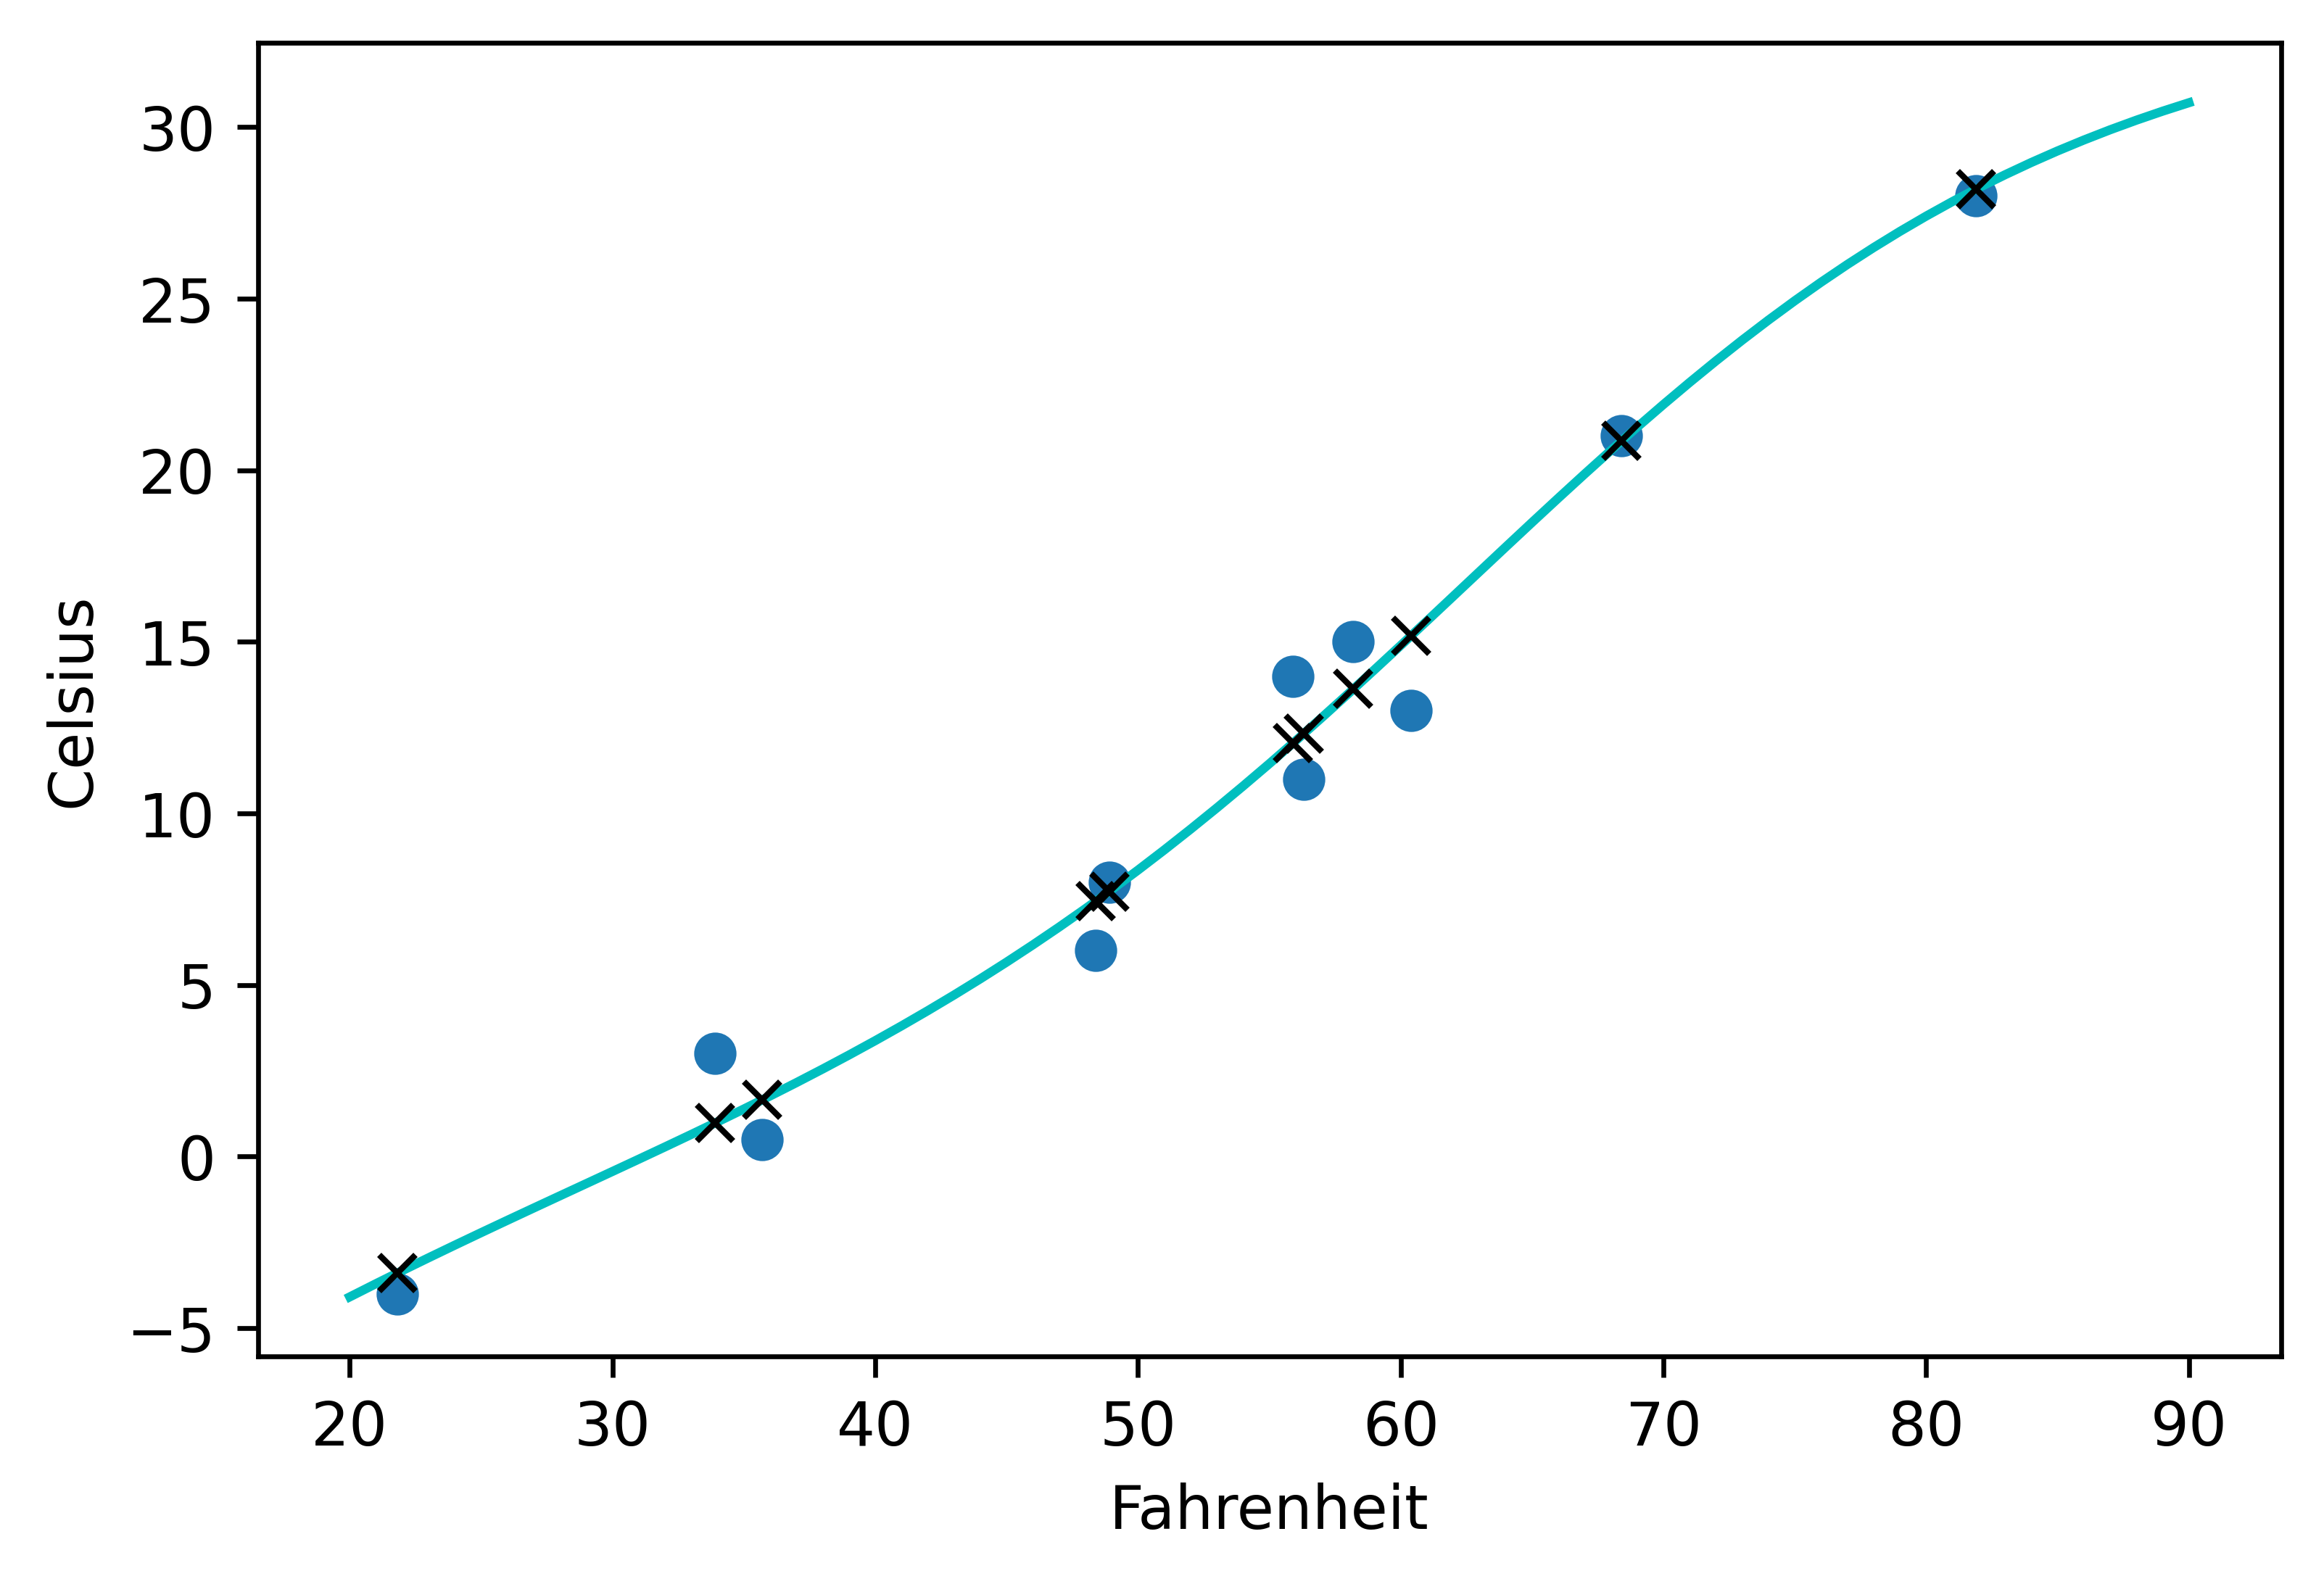

In [33]:
import matplotlib.pyplot as plt
t_range = torch.range(20., 90.).unsqueeze(1)
fig = plt.figure(dpi = 600)
plt.xlabel('Fahrenheit')
plt.ylabel('Celsius')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1*t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx')

We can appreciate that our Neural Network has a tendency to overfit and it chases the atual_points. Even our tiny neural network has too many parameters to fit the few measurements that we have. It does a good job though overall